In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from imutils import paths
%matplotlib inline


In [ ]:
!git clone https://github.com/mohammedtlili/truck_recommandation.git


fatal: destination path 'truck_recommandation' already exists and is not an empty directory.


In [ ]:
# Initialising the CNN
model = tf.keras.models.Sequential()

# Step 3: ADDING CONVOLUTION LAYER

In [ ]:
# 32 feature detectors with 3*3 dimensions so the convolution layer compose of 32 feature maps
# 128 by 128 dimensions with colored image(3 channels)  (tensorflow backend)
input_size = (128, 128)
model.add(tf.keras.layers.Convolution2D(32, 3, 3, input_shape = (*input_size, 3), activation = 'relu'))

# STEP 4: ADDING POOLING LAYER

In [ ]:
# reduce the size of feature maps and therefore reduce the number of nodes in the future fully connected layer (reduce time complexity, less compute intense without losing the performace). 2 by 2 deminsion is the recommended option
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# STEP 5: ADDING SECOND CONVOLUTION LAYER WITH POOLIING


In [ ]:
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

# STEP 6: ADDING THIRD CONVOLUTION LAYER WITH POOLIING

In [ ]:
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

# STEP 7: ADDING FLATTENING LAYER

In [ ]:
# flatten all the feature maps in the pooling layer into single vector
model.add(tf.keras.layers.Flatten())

STEP 8: ADDING A FULLY CONNECTED LAYER

In [ ]:
# making classic ann which compose of fully connected layers
# number of nodes in hidden layer (output_dim) (common practice is to take the power of 2)
model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
#model.add(layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units = 4, activation = 'softmax'))

# STEP 9: COMPILING THE MODEL

In [ ]:
# Compiling the CNN
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, History
import os

In [ ]:
#os.mkdir('model')
os.makedirs('model', exist_ok=True)

In [ ]:
#Model saving based on validation accuracy score
filepath="model/stage_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 42, 42, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 21, 21, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                  

# STEP 10: FITTING THE CNN TO THE IMAGES

In [ ]:
# image augmentation technique to enrich our dataset(training set) without adding more images
# so get good performance  results with little or no overfitting even with the small amount of images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0)



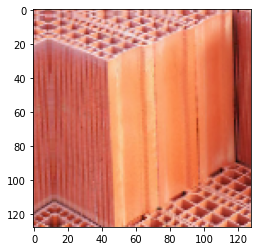

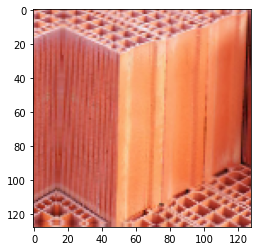

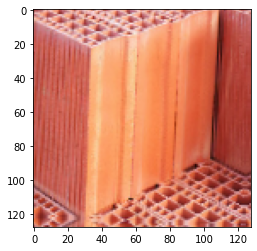

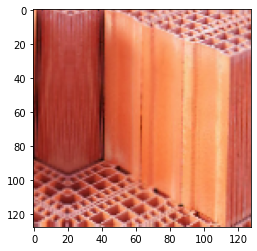

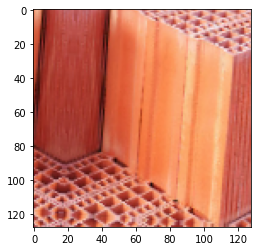

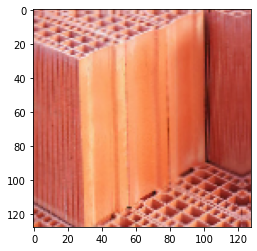

In [ ]:
img_path = '/content/truck_recommandation/dataset/train_set/camionette/Sans-titre-1-17.jpg'
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

In [ ]:
# used from keras documentation (flow_from_directory method)

batch_size = 32

In [ ]:


# create training set
# wanna get higher accuracy -> inccrease target_size
train_generator = train_datagen.flow_from_directory('/content/truck_recommandation/dataset/train_set',
                                                 target_size = input_size,
                                                 batch_size = batch_size,
                                                 class_mode = 'binary')





Found 14240 images belonging to 4 classes.


In [ ]:
train_generator.class_indices

{'camionette': 0, 'fourgon': 1, 'porteur': 2, 'utilitaire': 3}

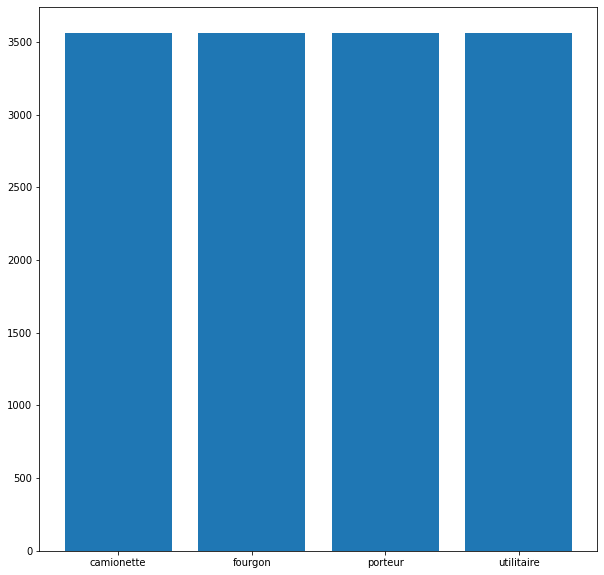

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(4):
    num_values.append(valdict[i])
plt.figure(figsize=(10,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


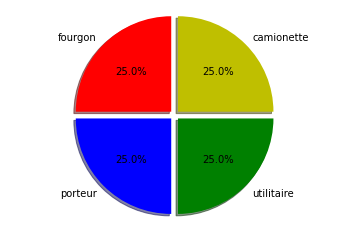

In [ ]:
import matplotlib.pyplot as plt
goal_types = list(train_generator.class_indices.keys())
unique, counts = np.unique(cls_train, return_counts=True)
goals = [(counts)]
colors = ['y','r','b','g']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

In [ ]:
# create test set
# wanna get higher accuracy -> inccrease target_size
test_generator = test_datagen.flow_from_directory('/content/truck_recommandation/dataset/test_set',
                                            target_size = input_size,
                                            batch_size = batch_size,
                                            class_mode = 'binary')

Found 3560 images belonging to 4 classes.


['camionette', 'fourgon', 'porteur', 'utilitaire']
[]
OrderedDict([(0, 890), (1, 890), (2, 890), (3, 890)])


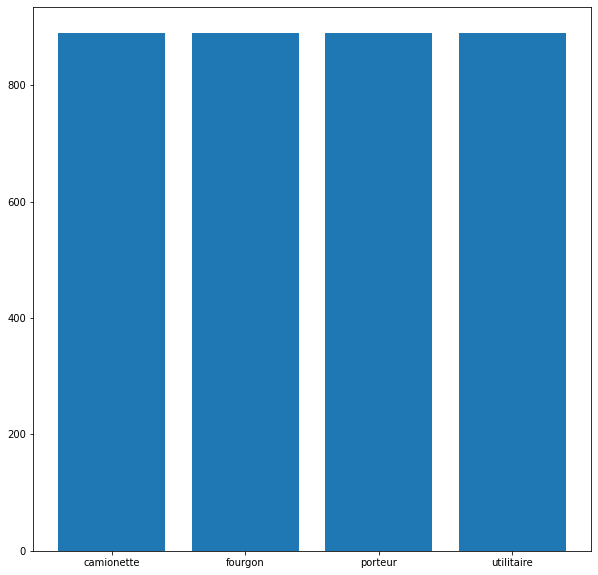

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_test = test_generator.classes
from collections import OrderedDict


classes = list(test_generator.class_indices.keys())
print(classes)
num_values = []
print(num_values)

unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
print(valdict)

for i in range(4):
  num_values.append(valdict[i])
plt.figure(figsize=(10,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


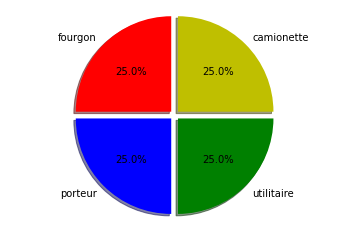

In [ ]:
import matplotlib.pyplot as plt

goal_types = list(test_generator.class_indices.keys())
unique, counts = np.unique(cls_test, return_counts=True)
goals = [(counts)]
colors = ['y','r','b','g']

plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')

plt.show()

In [ ]:
# fit the cnn model to the trainig set and testing it on the test set
his = tf.keras.callbacks.History()
model.fit(train_generator,
          steps_per_epoch = 14240/batch_size,
          epochs = 20,
          validation_data = test_generator,
          validation_steps = 3560/batch_size, callbacks=[his])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


445/445 [==============================] - 240s 538ms/step - loss: 1.2792 - accuracy: 0.3894 - val_loss: 1.2365 - val_accuracy: 0.4261
Epoch 2/20
445/445 [==============================] - 232s 521ms/step - loss: 1.1626 - accuracy: 0.4881 - val_loss: 1.2834 - val_accuracy: 0.4157
Epoch 3/20
445/445 [==============================] - 244s 548ms/step - loss: 1.1004 - accuracy: 0.5244 - val_loss: 1.2196 - val_accuracy: 0.4483
Epoch 4/20
445/445 [==============================] - 239s 536ms/step - loss: 1.0569 - accuracy: 0.5424 - val_loss: 1.1891 - val_accuracy: 0.4848
Epoch 5/20
445/445 [==============================] - 235s 528ms/step - loss: 1.0160 - accuracy: 0.5677 - val_loss: 1.3316 - val_accuracy: 0.4508
Epoch 6/20
445/445 [==============================] - 235s 527ms/step - loss: 0.9727 - accuracy: 0.5905 - val_loss: 1.1901 - val_accuracy: 0.4652
Epoch 7/20
445/445 [==============================] - 258s 580ms/step - loss: 0.9497 - accuracy: 0.6027 - val_loss: 1.1699 - val_accura

In [ ]:
test_score = model.evaluate_generator(test_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[INFO] accuracy: 50.00%
[INFO] Loss:  1.319818377494812


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

  camionette       0.24      0.26      0.25       890
     fourgon       0.26      0.38      0.31       890
     porteur       0.25      0.19      0.22       890
  utilitaire       0.23      0.16      0.19       890

    accuracy                           0.25      3560
   macro avg       0.25      0.25      0.24      3560
weighted avg       0.25      0.25      0.24      3560



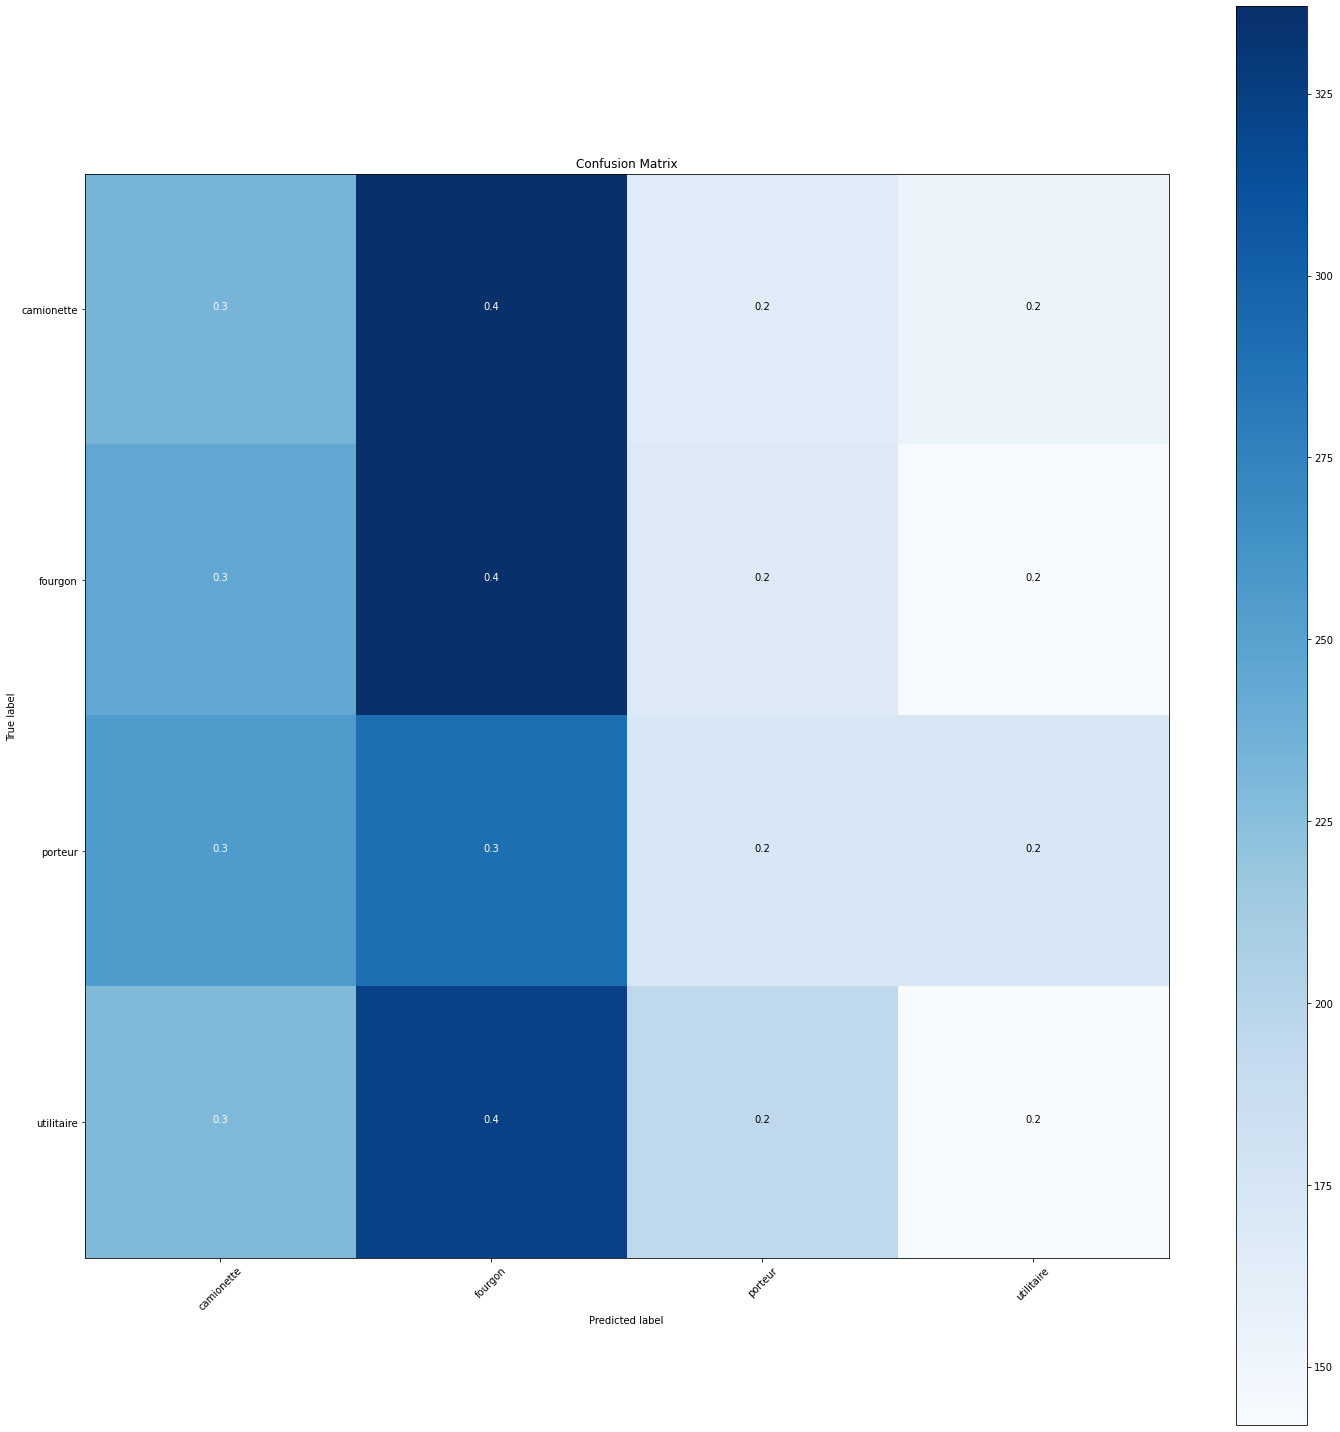

In [ ]:

from matplotlib import cm
import matplotlib.cm as cm
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Text(0.5, 1.0, 'Accuracy Curves')

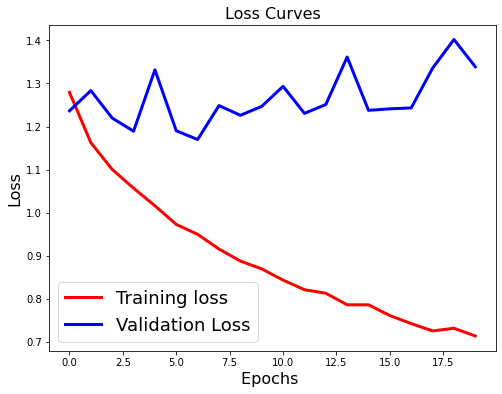

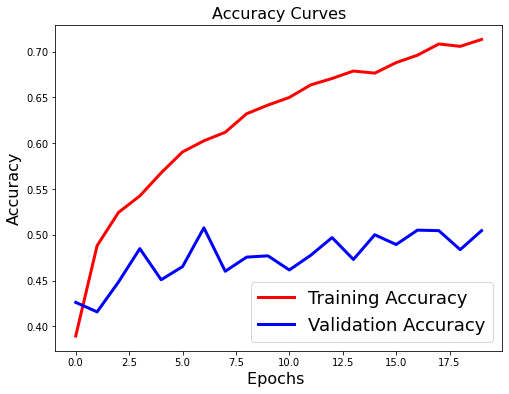

In [ ]:
##Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(his.history['loss'],'r',linewidth=3.0)
plt.plot(his.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(his.history['accuracy'],'r',linewidth=3.0)
plt.plot(his.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

# STEP 11: MAKING NEW PREDICTIONS

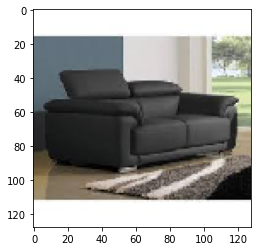

In [ ]:
img_path = '/content/truck_recommandation/dataset/single_prediction/images (2).jpg'

img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
plt.show()

In [ ]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

In [ ]:
prediction = model.predict(x)

In [ ]:
prediction

array([[0.14932092, 0.47344247, 0.07917508, 0.29806155]], dtype=float32)

In [ ]:
classes = np.argmax(prediction, axis = 1)
print(classes)

[1]
